# $n$-step Bootstrapping

MC - waiting till the end of episode - may be very long
<img src="http://1.bp.blogspot.com/-o3s_wTazl0o/T1DShNOXZ6I/AAAAAAAABCE/O3Yut_-2UIM/s1600/waiting.jpg" width="50%"/>

TD(0) - updating after each step - may not propagate significant state change: changing the mindset after each piece of experience.
<img src="https://s.abcnews.com/images/Health/gty_grocery_store_tk_130506_wmain.jpg" width="50%" />

Practically: the optimum is often somewhere in between.

What is the "in between"?

## $n$-step TD Prediction

Update after:
* More than *one* step.
* Less than *all* steps (=whole episode).

All steps:
$$
G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3}+\dots + \gamma^{T-t-1} R_T
$$

One step:
$$
G_{t:t+1} = R_{t+1} + \gamma V_t(S_{t+1}) 
$$

Let's try *two* steps:

$$
G_{t:t+1} = R_{t+1} +\gamma R_{t+2} + \gamma^2 V_{t+1}(S_{t+2}) 
$$

Generally:
$$
G_{t:t+n} = R_{t+1} +\gamma R_{t+2} + \dots \gamma^n V_{t+n-1}(S_{t+n}) 
$$

We have to take care of two things:

1. The end of the episode - what if $t+n\geq T$?

Answer: The missing terms are taken as zero.

<ol start="2">
    <li>
        We don't know $G_{t:t+1}$ at time $t$ - when to update it? 
    </li>
</ol>
Answer: we update at time $t+1$.

Let's go to the frozen lake.

In [44]:
import gym
import numpy as np

alpha = 0.05
gamma = 0.9
V = np.zeros(64)

env = gym.make('FrozenLake8x8-v0')
n = 5
for i_episode in range(20000):
    observation = env.reset()
    done = False
    t = 0
    T = np.infty
    S = {}
    R = {}
    while not done:
        # if episode is running
        if t<T:
            action = env.action_space.sample()
            S[t] = observation
            observation, reward, done, info = env.step(action)
            R[t] = reward
            if done:
                T = t + 1
        tau = t - n #+ 1
        
        # if we can update
        if tau >= 0:
            G = np.sum([gamma**(i-tau-1) +R[i] for i in range(tau+1,int(np.min([tau+n,T])))])
            if tau + n < T:
                G = G + gamma**n * V[S[tau+n]]
            V[S[tau]] += alpha*(G-V[S[tau]]) 
        t += 1
        done =  tau == T -1
            
        

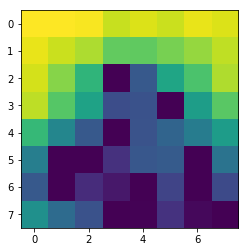

In [45]:
% matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(V.reshape(8,8))

In [46]:
import pandas as pd
pd.DataFrame(V.reshape(8,8))

,0,1,2,3,4,5,6,7
0,7.099567,7.108402,7.028883,6.500263,6.723588,6.547027,6.883820,6.727356
1,6.861582,6.540070,6.232767,5.414454,5.365273,5.641555,5.982388,6.417299
2,6.651836,5.825804,4.648283,0.000000,1.992539,4.189691,5.092994,6.253137
3,6.386901,5.233298,4.103259,1.674866,1.791372,0.000000,3.966079,5.285951
4,4.766004,3.268920,1.993131,0.000000,1.815021,2.292301,2.996863,3.916174
5,3.031698,0.000000,0.000000,1.016342,1.917488,2.032874,0.000000,2.699246
6,1.979926,0.000000,0.901247,0.460137,0.000000,1.455824,0.000000,1.605167
7,3.578940,2.480388,1.797067,0.000000,0.047500,1.044058,0.163353,0.000000



## $n$-step Sarsa

The we combine Sarsa with $n$-step approach like this:

$$
G_{t:t+n} = R_{t+1} + \gamma R_{t+2} +\dots + \gamma^{n-1} R_{t+n} + \gamma^{n}Q_{t+n-1}(S_{t+n},A_{t+n})
$$

In [47]:
import gym
import numpy as np

alpha = 0.05
gamma = 0.9
Q = np.zeros((64,4))

env = gym.make('FrozenLake8x8-v0')
n = 5
epsilon = 0.1
for i_episode in range(20000):
    observation = env.reset()
    done = False
    t = 0
    T = np.infty
    S = {}
    R = {}
    A = {}
    while not done:
        # if episode is running
        if t<T:
            if np.random.random()<epsilon:
                action = env.action_space.sample()
            else:
                action = Q[observation,:].argmax()
            S[t] = observation
            A[t] = action
            observation, reward, done, info = env.step(action)
            R[t] = reward
            if done:
                T = t + 1
        tau = t - n #+ 1
        
        # if we can update
        if tau >= 0:
            G = np.sum([gamma**(i-tau-1) +R[i] for i in range(tau+1,int(np.min([tau+n,T])))])
            if tau + n < T:
                G = G + gamma**n * V[S[tau+n]]
            Q[S[tau],A[tau]] += alpha*(G-Q[S[tau],A[tau]]) 
        t += 1
        done =  tau == T -1
            
        

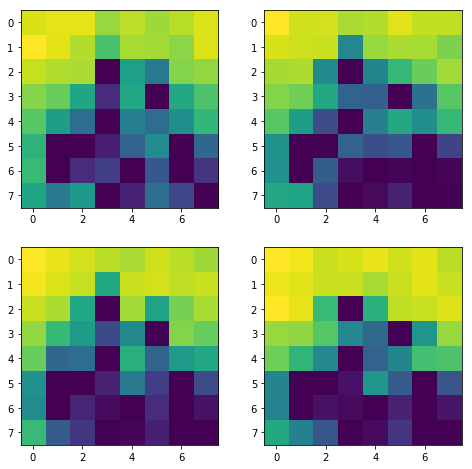

In [62]:
fig,axes = plt.subplots(2,2,figsize=(8,8))
for i in range(4):
    axes[int(np.floor(i/2)),i%2].imshow(Q[:,i].reshape((8,8)))

## $n$-step Off-policy Learning by Importance Sampling

Same principle as in case of MC. We consider the steps when it has been taken:

$$
V_{t+n}(S_t) = V_{t+n-1}(S_t) + \alpha \rho_{t:t+n-1} [G_{t:t+n} - V_{t+n-1}(S_t)]
$$

with the *importance sampling* ratio:

$$
\rho_{t:h} = \prod_{k=t}^{\min(h,T-1)}\frac{\pi(A_k|S_k)}{b(A_k|S_k)}
$$

Question: 

* What if $\pi(A_k|S_k)=0$ for an arbitrary $k$?

Similarly with Sarsa:
$$
Q_{t+n}(S_t,A_t) = Q_{t+n-1}(S_t,A_t) + \alpha \rho_{t+1:t+n-1} [G_{t:t+n} - V_{t+n-1}(S_t,A_t)]
$$

Question:

* Why do we use $\rho_{t+1:t+n-1}$ instead of $\rho_{t:t+n-1}$?
* What $\rho$ would be used for the expected Sarsa?


## Off-policy Learning Without Importance Sampling: The $n$-step Tree Backup Algorithm

How this can work in case of TD(0)?

* Expected Sarsa
* Q-learning

Why?

* Because no importance sampling needed (boosting only).

Trick here: **Backup Tree**:

$$
S_t - \mathcal{A}(S_t) - S_{t+1}- \mathcal{A}(S_{t+1}) - \dots - S_{t+n}- \mathcal{A}(S_{t+n})
$$

Approach:

* Weight of a leaf corresponds to probability of the corresponding sequence of actions going there. For an $A\in \mathcal{A}(S_k)$, it is $\product_{i=t}^k\pi(A_k|S_k)$.
* The rest is bootstrapped.


For a single step, it is just expected Sarsa:
$$
G_{t:t+1} = R_{t+1} + \gamma \sum_a \pi(a|S_{t+1}) Q_t(S_{t+1},a)
$$

Let's introduce $\delta'_t$:
$$
 G_{t:t+1} = \delta'_t + Q_{t-1}(S_t,A_t) 
$$

or (in the other words)
$$
\delta'_t = R_{t+1} + \gamma \sum_a \pi(a|S_{t+1}) Q_t(S_{t+1},a) - Q_{t-1}(S_t,A_t) 
$$

The calculation is recurrent like this:
$$
\begin{align}
G_{t:t+n} & = & R_{t+1}+\gamma \sum_{a\neq A_{t+1}} \pi(a|S_{t+1})Q_t(S_{t+1},a) + \gamma\pi(A_{t+1}|S_{t+1})G_{t+1:t+n} \\
 & = & \delta'_t + Q_{t-1}(S_t,A_t) - \gamma \pi(A_{t+1}|S_{t+1})Q_t(S_{t+1},A_{t+1}) + \gamma\pi(A_{t+1}|S_{t+1})G_{t+1:t+n} \\
 & = & Q_{t-1}(S_t,A_t) + \delta'_t + \gamma \pi(A_{t+1}|S_{t+1})\left( G_{t+1:t+n} - Q_t(S_{t+1},A_{t+1}) \right) \\
 & = & Q_{t-1}(S_t,A_t) + \delta'_t + \gamma \pi(A_{t+1}|S_{t+1}) \delta'_{t+1} + \gamma^2 \pi(A_{t+}|S_{t+1})\pi(A_{t+2}|S_{t+2}) \delta'_{t+2} + \dots \\
 & = & Q_{t-1}(S_t,A_t) + \sum_{k=t}^{\min(t+n-1,T-1)} \delta'_k \prod_{i=t+1}^{k}\gamma \pi(A_i|S_i)
\end{align}
$$



## Homework

- Obligatory: Implement the Backup Tree Algorithm and test it on the Frozen Lake or another environment

- Optional: 